In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datatable as dt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from datatable.models import Ftrl

In [5]:
df = pd.read_csv("C:\\OBS Studio\\self_case_study_file\\train_categorical.csv",nrows=100,low_memory = False)
columns = df.columns
lst = [0]*len(columns)

#This for loop counts the no of products passes through each sation
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_categorical.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    val = []
    columns = chunk_df.columns
    for i in columns:
        col = pd.Series(chunk_df[i])
        n = col.count()
        val.append(n)
    for i in range(len(lst)):
        lst[i] += val[i]

119it [02:55,  1.47s/it]


In [6]:
d = dict()#creating a dictionary where key is column name and value is the no of product passes through that line
for i in range(len(df.columns)):
    d[df.columns[i]] = lst[i]
imp_cols = []
for k,v in d.items():
    if v != 0:
        imp_cols.append(k)
len(imp_cols)

1978

In [7]:
#extracting all categories from train data
all_categories = []
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_categorical.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    for i in range(len(chunk_df)):
        row = chunk_df.iloc[i]
        for j in row[1:]:
            if str(j) != 'nan':
                if j not in all_categories:
                    all_categories.append(j)

119it [38:59, 19.66s/it]


In [8]:
#for nan values creating a new category not_passed
all_categories.append('not_passed')

In [56]:
#Numerical to categorical for train data
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
encoder.fit(np.array(all_categories).reshape(-1,1))

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [62]:
#Numerical to categorical for train data
first_itr = None
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_categorical.csv.zip',usecols = imp_cols, iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    chunk_df = chunk_df.fillna('not_passed') #replacing all the nan values with not_passed category
    chunk_df = chunk_df.drop('Id',axis=1)
    for i in range(len(chunk_df)):
        row = encoder.transform(np.array(chunk_df.iloc[i]).reshape(-1,1))
        chunk_df.iloc[i] = row.reshape(1,-1)[0]
    chunk_df = chunk_df.astype('int32')
    if first_itr is None:
        chunk_dt = dt.Frame(chunk_df) #convertinf pandas dataframe to datatables
        first_itr = 'Not None'
    else:
        dt_ = dt.Frame(chunk_df)
        chunk_dt.rbind(dt_)#joining all the dataset

119it [41:47, 21.07s/it]


In [67]:
#Numerical to categorical for test data
first_itr = None
for chunk_df_test in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_categorical.csv.zip',usecols = imp_cols, iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    chunk_df_test = chunk_df_test.fillna('not_passed')
    chunk_df_test = chunk_df_test.drop('Id',axis=1)
    for i in range(len(chunk_df_test)):
        row = encoder.transform(np.array(chunk_df_test.iloc[i]).reshape(-1,1))
        chunk_df_test.iloc[i] = row.reshape(1,-1)[0]
    chunk_df_test = chunk_df_test.astype('int32')
    if first_itr is None:
        chunk_dt_test = dt.Frame(chunk_df_test)
        first_itr = 'Not None'
    else:
        dt_ = dt.Frame(chunk_df_test)
        chunk_dt_test.rbind(dt_)

119it [42:06, 21.23s/it]


In [68]:
'''chunk_dt.to_csv("cat_to_nume.csv")'''

In [70]:
'''chunk_dt_test.to_csv("cat_to_nume_test.csv")'''

In [2]:
#reding with datatable
train = dt.fread('cat_to_nume.csv')

In [3]:
#normalizing the train data
from datatable import f, min, max
for col in tqdm(train.names):
    train[:,f[col]] = train[:, (f[col] - min(f[col]))/(max(f[col]) - min(f[col]))]

100%|██████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:50<00:00, 39.24it/s]


In [ ]:
'''train.to_csv('norm_cat_to_nume_train.csv')'''

In [2]:
#reading test data in datatable
test = dt.fread('cat_to_nume_test.csv')

In [ ]:
#normalizing test data
from datatable import f, min, max
for col in tqdm(test.names):
    test[:,f[col]] = test[:, (f[col] - min(f[col]))/(max(f[col]) - min(f[col]))]

In [ ]:
test.to_csv('norm_cat_to_nume_test.csv')

In [5]:
#converting target value to datatable
train_num = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_numeric.csv',usecols = ['Response'])
train_num_ = dt.Frame(train_num)
target = train_num_[:,'Response']

In [6]:
#train test split
X_train, X_valid = train[:800000, :], train[800000:, :]
y_train, y_valid = target[:800000, :], target[800000:, :]

In [9]:
#FTRL modelwith l1 and l2 regularization
model_ftrl = Ftrl(nepochs=5, nbins=10**8, lambda1=0.1,lambda2=1)
model_ftrl.fit(X_train, y_train, X_validation=X_valid, y_validation=y_valid)

FtrlFitOutput(epoch=2.0, loss=0.000644833198748529)

In [10]:
y_pred = model_ftrl.predict(train) #predicting the result 
y_pred_csv = y_pred.to_pandas()

In [13]:
y_pred_test = model_ftrl.predict(test) #predicting the kaggle test data
y_pred_test_csv = y_pred_test.to_pandas()

In [11]:
df_train = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_categorical.csv',usecols=["Id"])
df_test = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_categorical.csv',usecols=["Id"])

In [15]:
y_pred_csv['Id'] = df_train["Id"]

In [ ]:
y_pred_test_csv['Id'] = df_test["Id"]

In [16]:
y_pred_csv.head()

,Response,Id
0,-0.007993,4
1,-0.007993,6
2,-0.000175,7
3,-0.000175,9
4,-0.000175,11


In [17]:
y_pred_test_csv.head()

,Response,Id
0,-0.012659,1
1,0.004194,2
2,-0.007307,3
3,0.007195,5
4,0.003438,8


In [18]:
'''y_pred_csv.to_csv("final_categorical_train.csv")
y_pred_test_csv.to_csv("final_categorical_test.csv")'''

## In above case we just convert all our categorical features to a single numerical feature

In [2]:
#Train data
#creating some new engineered feature for categorical data
new_category_feature = pd.DataFrame()
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_categorical.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    df = chunk_df[['Id']].copy()
    df['no_of_category'] = chunk_df.count(axis=1)-1 #no of values except nan
    different_cat = []
    for i in range(len(chunk_df)):
        different_cat.append(len(chunk_df.iloc[i].value_counts())-1)
    df['different_category'] = different_cat #total no of different category used in a single product
    new_category_feature = pd.concat([new_category_feature,df])

119it [30:04, 15.17s/it]


In [9]:
probability_value = pd.read_csv('Model/final_categorical_train.csv')

In [11]:
new_category_feature['probability_value'] = probability_value

In [13]:
'''new_category_feature.to_csv('Model/final_categorical_train_2.0.csv')'''

In [3]:
#Test data
new_category_feature_test = pd.DataFrame()
for chunk_df_test in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_categorical.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    df_test = chunk_df_test[['Id']].copy()
    df_test['no_of_category'] = chunk_df_test.count(axis=1)-1
    different_cat = []
    for i in range(len(chunk_df_test)):
        different_cat.append(len(chunk_df_test.iloc[i].value_counts())-1)
    df_test['different_category'] = different_cat
    new_category_feature_test = pd.concat([new_category_feature_test,df_test])

119it [29:46, 15.01s/it]


In [4]:
probability_value_test = pd.read_csv('Model/final_categorical_test.csv')

In [5]:
new_category_feature_test['probability_value'] = probability_value_test

In [7]:
'''new_category_feature_test.to_csv('Model/final_categorical_test_2.0.csv')'''

# Numerical Data

In [3]:
#import pandas as pd
df_num = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_numeric.csv',nrows=600)

In [2]:
import pandas as pd
df_num = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_numeric.csv',nrows=600000)

In [3]:
y = df_num['Response']
X = df_num.drop(['Response','Id'],axis=1)

In [4]:
X = X.fillna(0)
X.head()

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#normalizing numerical data
normalized_X=(X-X.mean())/X.std()

In [6]:
normalized_X.head()

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,0.497934,-0.482128,-1.233059,-1.119464,1.658521,0.930460,-1.024871,-0.409402,0.231658,0.972234,...,0.0072,-0.000763,-0.004179,-0.003912,-0.005285,0.000822,0.010542,-0.001981,-0.006351,-0.002964
1,0.003089,0.003898,0.000888,0.001100,0.002731,0.000887,-0.000823,-0.000375,0.001604,0.000524,...,0.0072,-0.000763,-0.004179,-0.003912,-0.005285,0.000822,0.010542,-0.001981,-0.006351,-0.002964
2,1.454634,1.233258,0.019679,-0.324427,2.261902,0.201226,-1.024871,-0.920685,-2.586506,-1.720457,...,0.0072,-0.000763,-0.004179,-0.003912,-0.005285,0.000822,0.010542,-0.001981,-0.006351,-0.002964
3,-0.590725,-0.910975,1.842412,2.066944,1.041108,1.291070,1.501114,1.635731,-0.297467,-0.538014,...,0.0072,-0.000763,-0.004179,-0.003912,-0.005285,0.000822,0.010542,-0.001981,-0.006351,-0.002964
4,-0.904127,-1.225462,1.842412,2.066944,1.658521,0.201226,2.047272,2.147015,-1.942354,-1.158504,...,0.0072,-0.000763,-0.004179,-0.003912,-0.005285,0.000822,0.010542,-0.001981,-0.006351,-0.002964


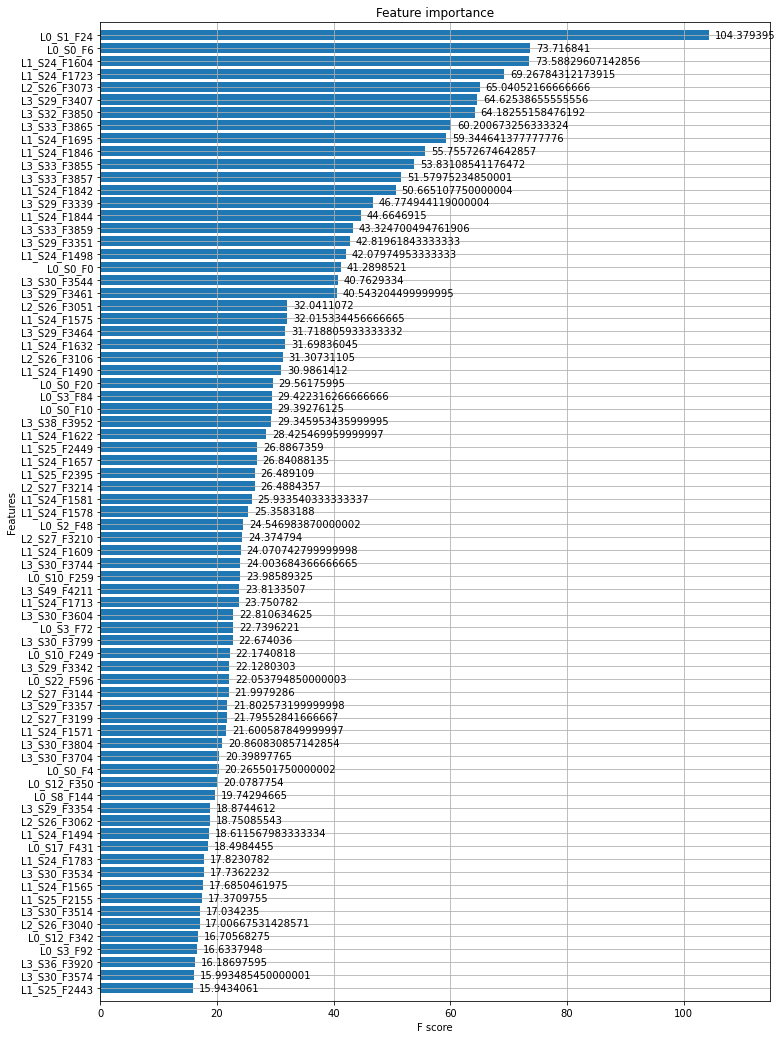

In [8]:
#Taking some important features from numerical data based on XGBoost on top 6lakh rows
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
fig, ax = plt.subplots(figsize=(12,18))
model = XGBClassifier(learning_rate=0.1, max_depth=3,\
min_child_weight=1, n_estimators=100, nthread=-1,use_label_encoder = False)
model.fit(X, y,eval_metric='auc')

xgb.plot_importance(model, max_num_features=75, height=0.8, ax=ax,importance_type='gain') #showing top 75 important features
plt.show()

In [12]:
#credit:- https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost
sorted_idx = np.argsort(model.feature_importances_)[::-1] #storing all the top 75 features
top_imp_features = ["Id"]
n = 0
for index in tqdm(sorted_idx):
    if n<100:
        n+=1
        top_imp_features.append(X.columns[index])

100%|████████████████████████████████████████████████████████████████████████████| 968/968 [00:00<00:00, 322767.01it/s]


In [13]:
top_imp_features.append("Response")

In [16]:
top_imp_features[:-1]

['Id',
 'L0_S1_F24',
 'L0_S0_F6',
 'L1_S24_F1604',
 'L1_S24_F1723',
 'L2_S26_F3073',
 'L3_S29_F3407',
 'L3_S32_F3850',
 'L3_S33_F3865',
 'L1_S24_F1695',
 'L1_S24_F1846',
 'L3_S33_F3855',
 'L3_S33_F3857',
 'L1_S24_F1842',
 'L3_S29_F3339',
 'L1_S24_F1844',
 'L3_S33_F3859',
 'L3_S29_F3351',
 'L1_S24_F1498',
 'L0_S0_F0',
 'L3_S30_F3544',
 'L3_S29_F3461',
 'L2_S26_F3051',
 'L1_S24_F1575',
 'L3_S29_F3464',
 'L1_S24_F1632',
 'L2_S26_F3106',
 'L1_S24_F1490',
 'L0_S0_F20',
 'L0_S3_F84',
 'L0_S0_F10',
 'L3_S38_F3952',
 'L1_S24_F1622',
 'L1_S25_F2449',
 'L1_S24_F1657',
 'L1_S25_F2395',
 'L2_S27_F3214',
 'L1_S24_F1581',
 'L1_S24_F1578',
 'L0_S2_F48',
 'L2_S27_F3210',
 'L1_S24_F1609',
 'L3_S30_F3744',
 'L0_S10_F259',
 'L3_S49_F4211',
 'L1_S24_F1713',
 'L3_S30_F3604',
 'L0_S3_F72',
 'L3_S30_F3799',
 'L0_S10_F249',
 'L3_S29_F3342',
 'L0_S22_F596',
 'L2_S27_F3144',
 'L3_S29_F3357',
 'L2_S27_F3199',
 'L1_S24_F1571',
 'L3_S30_F3804',
 'L3_S30_F3704',
 'L0_S0_F4',
 'L0_S12_F350',
 'L0_S8_F144',
 'L3_S29_

In [12]:
import joblib
joblib.dump(top_imp_features,'Deployment/imp_numerical_features_name.pkl')

['Deployment/imp_numerical_features_name.pkl']

In [17]:
df_imp_num = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_numeric.csv',usecols = top_imp_features)
df_imp_num_test = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_numeric.csv',usecols = top_imp_features[:-1])

In [18]:
df_imp_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F10,L0_S0_F14,L0_S0_F20,L0_S1_F24,L0_S2_F48,...,L3_S33_F3857,L3_S33_F3859,L3_S33_F3865,L3_S36_F3920,L3_S38_F3952,L3_S38_F3956,L3_S41_F4000,L3_S41_F4016,L3_S49_F4211,Response
0,4,0.030,-0.034,-0.197,-0.179,0.116,-0.032,-0.273,-0.271,0.001,...,-0.102,-0.048,0.026,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.026,-0.210,-0.047,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.025,-0.072,0.250,0.057,-0.005,...,0.191,0.236,0.108,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.161,0.128,-0.253,0.147,0.005,...,0.031,0.165,0.035,-0.030,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.025,0.168,0.042,-0.012,NaN,...,-0.049,0.147,-0.006,0.083,NaN,NaN,NaN,NaN,NaN,0


In [19]:
'''df_imp_num.to_csv('final_numeric_features_train.csv')
df_imp_num_test.to_csv('final_numeric_features_test.csv')'''

In [8]:
new_numerical_feature = pd.DataFrame()
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_numeric.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    chunk_df.fillna(0,inplace=True)
    df = chunk_df[['Id']].copy()
    chunk_df.drop('Id',axis=1,inplace=True)
    df['max_num_value'] = chunk_df.max(axis=1).values
    df['min_num_value'] = chunk_df.min(axis=1).values
    df['mean_num_value'] = chunk_df.mean(axis=1).values
    new_numerical_feature = pd.concat([new_numerical_feature,df])

119it [01:37,  1.21it/s]


In [5]:
df_num = pd.read_csv('Model/final_numeric_features_train.csv').drop('Unnamed: 0',axis=1)

In [9]:
final_num_feature = pd.merge(df_num,new_numerical_feature,on="Id")

In [11]:
final_num_feature.fillna(0,inplace=True)

In [13]:
'''final_num_feature.to_csv('Model/final_numeric_features_train_2.0.csv')'''

In [7]:
new_numerical_feature_test = pd.DataFrame()
for chunk_df_test in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_numeric.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    chunk_df_test.fillna(0,inplace=True)
    df_test = chunk_df_test[['Id']].copy()
    chunk_df_test.drop('Id',axis=1,inplace=True)
    df_test['max_num_value'] = chunk_df_test.max(axis=1).values
    df_test['min_num_value'] = chunk_df_test.min(axis=1).values
    df_test['mean_num_value'] = chunk_df_test.mean(axis=1).values
    new_numerical_feature_test = pd.concat([new_numerical_feature_test,df_test])

0it [00:01, ?it/s]


NameError: name 'chunk_df' is not defined

In [4]:
df_num_test = pd.read_csv('Model/final_numeric_features_test.csv').drop('Unnamed: 0',axis=1)
final_num_feature_test = pd.merge(df_num_test,new_numerical_feature_test,on="Id")
final_num_feature_test.fillna(0,inplace=True)

In [6]:
'''final_num_feature_test.to_csv('Model/final_numeric_features_test_2.0.csv')'''

# Date Feature

In [5]:
df_date = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv',nrows=1000)

In [5]:
diff_line_date = [] #store all the different production lines
diff_st_date = [] #store all the different stations
diff_time = [] #store all the different feature number
columns_date = df_date.columns
for i in range(1,len(columns_date)): #iterating every column except Id
    feature = columns_date[i]
    lst = feature.split("_") #spliting the feature name into line,station and feature number name 
    
    #storing line,station and feature number name in different variable
    line = lst[0]
    st = lst[1]
    fn = lst[2]
    
    if line not in diff_line_date: #selecting different production line 
        diff_line_date.append(line)
    if st not in diff_st_date: #selecting different stations
        diff_st_date.append(st)
    if fn not in diff_time: #selecting different feature number
        diff_time.append(fn)
print(diff_line_date)
print(len(diff_line_date))
print(diff_st_date)
print(len(diff_st_date))
#print(diff_time)
print(len(diff_time))

['L0', 'L1', 'L2', 'L3']
4
['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39', 'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49', 'S50', 'S51']
52
1156


In [10]:
count_dict_ = dict() 
"""
In the above dictionary key is the station name and value is the top 2 imp feature for each station
"""
for station in tqdm(diff_st_date): #iterating every station
    lst = [] #storing all the features name based on current station
    for i in df_date.columns:
        if station in i.split("_"):
            lst.append(i)
            
    n = [0]*len(lst) 
    #In the above list storing those station features where maximum no of products passes through it
    
    for chunk_df in pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False):
        count = []
        df = chunk_df[lst]
        for i in df.columns:
            c = df[i].count() #counting total no of date values(ignoring nan value) in a single row
            count.append(c) 
        for j in range(len(count)):
            n[j] += count[j]
            
    if len(n)>=2:
        max_val_1 = max(n) #storing max value
        max_val_index_1 = n.index(max_val_1) #storing the station which have maximum no of products passes through it
        col_name_1 = lst[max_val_index_1]
        n[max_val_index_1] = -1
        max_val_2 = max(n) #storing second largest value 
        max_val_index_2 = n.index(max_val_2) #storing second largest feature
        col_name_2 = lst[max_val_index_2]
        val = [[col_name_1,max_val_1],[col_name_2,max_val_2]]
    else:
        max_val_1 = max(n)
        max_val_index_1 = n.index(max_val_1)
        col_name_1 = lst[max_val_index_1]
        val = [[col_name_1,max_val_1]]
    
    count_dict_[station] = val

100%|████████████████████████████████████████████████████████████████████████████████| 52/52 [1:06:28<00:00, 76.70s/it]


In [24]:
#storing all the important columns
imp_cols = []
for i in diff_st_date:
    if len(count_dict_[i]) == 2:
        imp_cols.append(count_dict_[i][0][0])
        imp_cols.append(count_dict_[i][1][0])
    elif len(count_dict_[i]) == 1:
        imp_cols.append(count_dict_[i][0][0])

In [30]:
imp_date_feature =  pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv',usecols = imp_cols)

In [31]:
'''imp_date_feature.to_csv('imp_date_feature')'''

In [8]:
df = pd.read_csv('imp_date_feature')

In [16]:
len(imp_date_cols_name)

103

In [11]:
imp_date_cols_name = df.columns

In [13]:
joblib.dump(imp_date_cols_name,'Deployment/imp_date_cols_name.pkl')

['Deployment/imp_date_cols_name.pkl']

In [3]:
df = pd.read_csv("imp_date_feature").drop('Unnamed: 0',axis=1)
cols = df.columns
df_test = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv',usecols = cols)

In [5]:
st = []
col = []
for i in cols:
    if i.split("_")[1] not in st:
        st.append(i.split("_")[1])
        col.append(i)

In [8]:
#doing same thing for test data
df_test = df_test[col]

In [88]:
'''df_test.to_csv('imp_date_feature_test')'''

In [96]:
#station one hot encoding
cols = []
for i in diff_st_date:
    if len(count_dict_[i]) == 2:
        cols.append(count_dict_[i][0][0])
    elif len(count_dict_[i]) == 1:
        cols.append(count_dict_[i][0][0])
ohe_station = pd.DataFrame(columns=diff_st_date)
df = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv',usecols = cols)

In [97]:
"""
From the EDA i saw that except S24 and S25 station all the products 
that passes through a particular station, it also passes through a single 
common feature related to that station. That's why I have done one hot encoding 
of all the station using top 2 feature of that station excepot S24 and S25 which
I have done manually with by counting all the features related to these 2 station.
"""
leave_col = ['S24','S25']
for col in tqdm(df.columns):
    lst = [0]*len(df)
    st = col.split("_")[1]
    if st not in leave_col:
        temp = df[col]
        for i in range(len(temp)):
            val = temp.iloc[i]
            if str(val) != 'nan':
                lst[i] = 1
    ohe_station[st] = lst

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [05:07<00:00,  5.92s/it]


In [98]:
col_24 = []
col_25 = []
#doing one hot encoding of of S24 and S25 station 
for i in df_date.columns:
    if 'S24' in i.split("_"):
        col_24.append(i)
    if 'S25' in i.split("_"):
        col_25.append(i)

In [100]:
df_24 = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv',usecols = col_24)
df_25 = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv',usecols = col_25)

In [101]:
n_24 = [0]*len(df_24)
for i in tqdm(range(len(df_24))):
    row = df_24.iloc[i]
    if row.count() != 0:
        n_24[i] = 1
ohe_station['S24'] = n_24

100%|█████████████████████████████████████████████████████████████████████| 1183747/1183747 [01:16<00:00, 15520.95it/s]


In [102]:
n_25 = [0]*len(df_25)
for i in tqdm(range(len(df_25))):
    row = df_25.iloc[i]
    if row.count() != 0:
        n_25[i] = 1
ohe_station['S25'] = n_25

100%|█████████████████████████████████████████████████████████████████████| 1183747/1183747 [01:13<00:00, 16058.86it/s]


In [12]:
'''ohe_station.to_csv("ohe_station")'''

In [2]:
ohe_station = pd.read_csv('ohe_station')
ohe_station.head()

,Unnamed: 0,S0,S1,S2,S3,S4,S5,S6,S7,S8,...,S42,S43,S44,S45,S46,S47,S48,S49,S50,S51
0,0,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [43]:
ohe_station = ohe_station.drop("Unnamed: 0",axis=1)

In [44]:
start_station = []
end_station = []
path_length = []
for i in tqdm(range(len(ohe_station))):
    row = ohe_station.iloc[i]
    start = 0
    end = 0
    
    for j in range(len(row)):
        if row[j] == 1:
            start = j
            break
    for k in range(len(row)-1,-1,-1):
        if row[k] == 1:
            end = k
            break
    path_length.append(np.count_nonzero(row == 1))
    start_station.append(start)
    end_station.append(end)

100%|██████████████████████████████████████████████████████████████████████| 1183747/1183747 [05:23<00:00, 3664.56it/s]


In [45]:
ohe_station['start_station'] = start_station
ohe_station['end_station'] = end_station
ohe_station['path_length'] = path_length

In [46]:
df = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv.zip',usecols = ['Id'])
ohe_station['Id'] = df['Id']
ohe_station.head(5)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S46,S47,S48,S49,S50,S51,start_station,end_station,path_length,Id
0,1,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,37,14,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,12,37,13,6
2,1,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,37,13,7
3,1,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,37,13,9
4,1,1,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,37,13,11


In [2]:
#credit:-https://www.kaggle.com/choithuthoi/my-solution

new_date_feature = pd.DataFrame()
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    columns = chunk_df.columns[1:] 
    df = chunk_df[['Id']].copy()
    df['mintime'] = chunk_df[columns].min(axis=1).values
    df['maxtime'] = chunk_df[columns].max(axis=1).values
    df['time_difference'] =  df['maxtime'] - df['mintime']
    df.fillna(0,inplace=True)
    week_duration = 1679
    
    df['part_week'] = ((df['mintime'].values * 100)  % week_duration).astype(np.int64)
    df['min_time_station'] =  chunk_df[columns].idxmin(axis = 1).apply(lambda s: int(s.split('_')[1][1:]) if s is not np.nan else -1)
    df['max_time_station'] =  chunk_df[columns].idxmax(axis = 1).apply(lambda s: int(s.split('_')[1][1:]) if s is not np.nan else -1)
    new_date_feature = pd.concat([new_date_feature,df])

119it [05:06,  2.58s/it]


In [36]:
#credit:-https://www.kaggle.com/choithuthoi/my-solution
new_date_feature.sort_values(by=['mintime', 'Id'], inplace=True)
new_date_feature['mindate_id_diff'] = new_date_feature.Id.diff()
midr = np.full_like(new_date_feature.mindate_id_diff.values, np.nan)
midr[0:-1] = -new_date_feature.mindate_id_diff.values[1:]
new_date_feature['mindate_id_diff_reverse'] = midr

In [39]:
new_date_feature.sort_values(by=['Id'],inplace=True)

In [40]:
new_date_feature.head()

,Id,mintime,maxtime,time_difference,part_week,min_time_station,max_time_station,mindate_id_diff,mindate_id_diff_reverse
0,4,82.24,87.29,5.05,1508,0,35,-2314450.0,-224451.0
1,6,1313.12,1315.75,2.63,350,12,33,-943242.0,-67530.0
2,7,1618.70,1624.42,5.72,686,0,33,-2313512.0,-26876.0
3,9,1149.20,1154.16,4.96,748,0,36,-2196581.0,-7838.0
4,11,602.64,606.02,3.38,1499,0,36,-2226678.0,-6827.0


In [47]:
final_date_feature = pd.merge(new_date_feature,ohe_station,on = 'Id')
final_date_feature.head()

,Id,mintime,maxtime,time_difference,part_week,min_time_station,max_time_station,mindate_id_diff,mindate_id_diff_reverse,S0,...,S45,S46,S47,S48,S49,S50,S51,start_station,end_station,path_length
0,4,82.24,87.29,5.05,1508,0,35,-2314450.0,-224451.0,1,...,0,0,0,0,0,0,0,0,37,14
1,6,1313.12,1315.75,2.63,350,12,33,-943242.0,-67530.0,0,...,0,0,0,0,0,0,0,12,37,13
2,7,1618.70,1624.42,5.72,686,0,33,-2313512.0,-26876.0,1,...,0,0,0,0,0,0,0,0,37,13
3,9,1149.20,1154.16,4.96,748,0,36,-2196581.0,-7838.0,1,...,0,0,0,0,0,0,0,0,37,13
4,11,602.64,606.02,3.38,1499,0,36,-2226678.0,-6827.0,1,...,0,0,0,0,0,0,0,0,37,13


In [48]:
df = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv.zip',usecols = ['Id'])
imp_date_feature = pd.read_csv("imp_date_feature")
imp_date_feature = imp_date_feature.drop("Unnamed: 0",axis=1)
imp_date_feature['Id'] = df['Id']
imp_date_feature.head()

,L0_S0_D1,L0_S0_D3,L0_S1_D26,L0_S1_D30,L0_S2_D34,L0_S2_D38,L0_S3_D70,L0_S3_D74,L0_S4_D106,L0_S4_D111,...,L3_S47_D4145,L3_S48_D4194,L3_S48_D4195,L3_S49_D4218,L3_S49_D4223,L3_S50_D4242,L3_S50_D4244,L3_S51_D4255,L3_S51_D4257,Id
0,82.24,82.24,82.24,82.24,82.24,82.24,NaN,NaN,82.26,82.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,1149.20,1149.20,1149.20,1149.20,1149.21,1149.21,NaN,NaN,1149.22,1149.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
4,602.64,602.64,602.64,602.64,NaN,NaN,602.64,602.64,602.66,602.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [49]:
imp_date_feature = imp_date_feature.fillna(0)

In [50]:
final_date_feature = pd.merge(final_date_feature,imp_date_feature,on='Id')

In [51]:
final_date_feature.head()

,Id,mintime,maxtime,time_difference,part_week,min_time_station,max_time_station,mindate_id_diff,mindate_id_diff_reverse,S0,...,L3_S47_D4140,L3_S47_D4145,L3_S48_D4194,L3_S48_D4195,L3_S49_D4218,L3_S49_D4223,L3_S50_D4242,L3_S50_D4244,L3_S51_D4255,L3_S51_D4257
0,4,82.24,87.29,5.05,1508,0,35,-2314450.0,-224451.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,1313.12,1315.75,2.63,350,12,33,-943242.0,-67530.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1618.70,1624.42,5.72,686,0,33,-2313512.0,-26876.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,1149.20,1154.16,4.96,748,0,36,-2196581.0,-7838.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,602.64,606.02,3.38,1499,0,36,-2226678.0,-6827.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
'''final_date_feature.to_csv('final_date_feature_train.csv')'''

In [3]:
line = ['L0','L1','L2','L3']
d = {} #key=station name and value=all the date feature related to that station
for l in line:
    lst = []
    for i in df_date.columns[1:]:
        t = i.split("_")
        if l in t:
            lst.append(i)
    d[l] = lst

In [4]:
#total no of feature related to each production line / how many features visited by the product
fraction_of_measurements = pd.DataFrame()
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\train_date.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    df = chunk_df[['Id']].copy()
    for l in line:
        col = d[l]
        temp = chunk_df[col]
        df['fraction_of_measurements'+l] = temp.count(axis=1)/len(col)
    fraction_of_measurements = pd.concat([fraction_of_measurements,df])

119it [01:26,  1.38it/s]


In [6]:
final_date_train = pd.read_csv('Model/final_date_feature_train.csv')

In [11]:
final_date_train['average_time_per_measurement'] = final_date_train['time_difference']/final_date_train['path_length']

In [14]:
final_date_train.drop('Unnamed: 0',axis=1,inplace=True)

In [16]:
final_date_features = pd.merge(final_date_train,fraction_of_measurements,on="Id")

In [19]:
'''final_date_features.to_csv('Model/final_date_feature_train_2.0.csv')'''

# Test Data

In [60]:
cols = []
station = []
for i in df_test.columns:
    st = i.split("_")[1]
    if st not in station:
        station.append(st)
        cols.append(i)

In [78]:
ohe_station_test = pd.DataFrame(columns=diff_st_date)
df_test_ = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv',usecols = cols)

In [79]:
leave_col = ['S24','S25']
for col in tqdm(df_test_.columns):
    lst = [0]*len(df_test_)
    st = col.split("_")[1]
    if st not in leave_col:
        temp = df_test_[col]
        for i in range(len(temp)):
            val = temp.iloc[i]
            if str(val) != 'nan':
                lst[i] = 1
    ohe_station_test[st] = lst

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [05:02<00:00,  5.83s/it]


In [80]:
col_24 = []
col_25 = []
for i in df_date.columns:
    if 'S24' in i.split("_"):
        col_24.append(i)
    if 'S25' in i.split("_"):
        col_25.append(i)

In [81]:
df_24 = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv',usecols = col_24)
df_25 = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv',usecols = col_25)

In [82]:
n_24 = [0]*len(df_24)
for i in tqdm(range(len(df_24))):
    row = df_24.iloc[i]
    if row.count() != 0:
        n_24[i] = 1
ohe_station_test['S24'] = n_24

100%|█████████████████████████████████████████████████████████████████████| 1183748/1183748 [01:15<00:00, 15672.59it/s]


In [83]:
n_25 = [0]*len(df_25)
for i in tqdm(range(len(df_25))):
    row = df_25.iloc[i]
    if row.count() != 0:
        n_25[i] = 1
ohe_station_test['S25'] = n_25

100%|█████████████████████████████████████████████████████████████████████| 1183748/1183748 [01:12<00:00, 16398.20it/s]


In [84]:
'''ohe_station_test.to_csv("ohe_station_test")'''

In [2]:
ohe_station_test = pd.read_csv('ohe_station_test')
ohe_station_test = ohe_station_test.drop("Unnamed: 0",axis=1)

In [3]:
start_station = []
end_station = []
path_length = []
for i in tqdm(range(len(ohe_station_test))):
    row = ohe_station_test.iloc[i]
    start = 0
    end = 0
    
    for j in range(len(row)):
        if row[j] == 1:
            start = j
            break
    for k in range(len(row)-1,-1,-1):
        if row[k] == 1:
            end = k
            break
    path_length.append(np.count_nonzero(row == 1))
    start_station.append(start)
    end_station.append(end)

100%|██████████████████████████████████████████████████████████████████████| 1183748/1183748 [05:32<00:00, 3560.64it/s]


In [4]:
ohe_station_test['start_station'] = start_station
ohe_station_test['end_station'] = end_station
ohe_station_test['path_length'] = path_length

In [5]:
df = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv.zip',usecols = ['Id'])
ohe_station_test['Id'] = df['Id']
ohe_station_test.head(5)

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S46,S47,S48,S49,S50,S51,start_station,end_station,path_length,Id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,37,8,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,37,8,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,37,8,3
3,1,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,37,14,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,24,37,8,8


In [6]:
new_date_feature_test = pd.DataFrame()
for chunk_df in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    columns = chunk_df.columns[1:] 
    df = chunk_df[['Id']].copy()
    df['mintime'] = chunk_df[columns].min(axis=1).values
    df['maxtime'] = chunk_df[columns].max(axis=1).values
    df['time_difference'] =  df['maxtime'] - df['mintime']
    
    df.fillna(0,inplace=True)
    week_duration = 1679
    
    df['part_week'] = ((df['mintime'].values * 100)  % week_duration).astype(np.int64)
    df['min_time_station'] =  chunk_df[columns].idxmin(axis = 1).apply(lambda s: int(s.split('_')[1][1:]) if s is not np.nan else -1)
    df['max_time_station'] =  chunk_df[columns].idxmax(axis = 1).apply(lambda s: int(s.split('_')[1][1:]) if s is not np.nan else -1)
    new_date_feature_test = pd.concat([new_date_feature_test,df])

119it [02:21,  1.19s/it]


In [8]:
#credit:-https://www.kaggle.com/choithuthoi/my-solution
new_date_feature_test.sort_values(by=['mintime', 'Id'], inplace=True)
new_date_feature_test['mindate_id_diff'] = new_date_feature_test.Id.diff()
midr = np.full_like(new_date_feature_test.mindate_id_diff.values, np.nan)
midr[0:-1] = -new_date_feature_test.mindate_id_diff.values[1:]
new_date_feature_test['mindate_id_diff_reverse'] = midr

In [9]:
new_date_feature_test.sort_values(by=['Id'],inplace=True)

In [11]:
new_date_feature_test.head()

,Id,mintime,maxtime,time_difference,part_week,min_time_station,max_time_station,mindate_id_diff,mindate_id_diff_reverse
0,1,792.72,800.70,7.98,359,24,34,-2324187.0,-3232.0
1,2,1025.63,1060.07,34.44,144,24,36,-2353739.0,-5943.0
2,3,671.92,711.08,39.16,32,24,34,-2357112.0,-24124.0
3,5,255.45,256.28,0.83,360,0,36,-2362588.0,-63560.0
4,8,743.38,770.28,26.90,462,24,33,-1856001.0,-1133098.0


In [12]:
final_date_feature_test = pd.merge(new_date_feature_test,ohe_station_test,on = 'Id')
final_date_feature_test.head()

,Id,mintime,maxtime,time_difference,part_week,min_time_station,max_time_station,mindate_id_diff,mindate_id_diff_reverse,S0,...,S45,S46,S47,S48,S49,S50,S51,start_station,end_station,path_length
0,1,792.72,800.70,7.98,359,24,34,-2324187.0,-3232.0,0,...,0,0,0,0,0,0,0,24,37,8
1,2,1025.63,1060.07,34.44,144,24,36,-2353739.0,-5943.0,0,...,0,0,0,0,0,0,0,24,37,8
2,3,671.92,711.08,39.16,32,24,34,-2357112.0,-24124.0,0,...,0,0,0,0,0,0,0,24,37,8
3,5,255.45,256.28,0.83,360,0,36,-2362588.0,-63560.0,1,...,0,0,0,0,0,0,0,0,37,14
4,8,743.38,770.28,26.90,462,24,33,-1856001.0,-1133098.0,0,...,0,0,0,0,0,0,0,24,37,8


In [13]:
df = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv.zip',usecols = ['Id'])
imp_date_feature_test = pd.read_csv("imp_date_feature_test")
imp_date_feature_test = imp_date_feature_test.drop("Unnamed: 0",axis=1)
imp_date_feature_test['Id'] = df['Id']
imp_date_feature_test.head()

,L0_S0_D1,L0_S0_D3,L0_S1_D26,L0_S1_D30,L0_S2_D34,L0_S2_D38,L0_S3_D70,L0_S3_D74,L0_S4_D106,L0_S4_D111,...,L3_S47_D4145,L3_S48_D4194,L3_S48_D4195,L3_S49_D4218,L3_S49_D4223,L3_S50_D4242,L3_S50_D4244,L3_S51_D4255,L3_S51_D4257,Id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,255.45,255.45,255.45,255.45,255.46,255.46,NaN,NaN,255.48,255.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [14]:
imp_date_feature_test = imp_date_feature_test.fillna(0)
final_date_feature_test = pd.merge(final_date_feature_test,imp_date_feature_test,on='Id')

In [15]:
final_date_feature_test.head()

,Id,mintime,maxtime,time_difference,part_week,min_time_station,max_time_station,mindate_id_diff,mindate_id_diff_reverse,S0,...,L3_S47_D4140,L3_S47_D4145,L3_S48_D4194,L3_S48_D4195,L3_S49_D4218,L3_S49_D4223,L3_S50_D4242,L3_S50_D4244,L3_S51_D4255,L3_S51_D4257
0,1,792.72,800.70,7.98,359,24,34,-2324187.0,-3232.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1025.63,1060.07,34.44,144,24,36,-2353739.0,-5943.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,671.92,711.08,39.16,32,24,34,-2357112.0,-24124.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,255.45,256.28,0.83,360,0,36,-2362588.0,-63560.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,743.38,770.28,26.90,462,24,33,-1856001.0,-1133098.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
'''final_date_feature_test.to_csv('final_date_feature_test.csv')'''

In [2]:
df_date_test = pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv',nrows=1000)

In [3]:
line = ['L0','L1','L2','L3']
d = {}
for l in line:
    lst = []
    for i in df_date_test.columns[1:]:
        t = i.split("_")
        if l in t:
            lst.append(i)
    d[l] = lst

In [4]:
fraction_of_measurements_test = pd.DataFrame()
for chunk_df_test in tqdm(pd.read_csv('C:\\OBS Studio\\self_case_study_file\\test_date.csv.zip',iterator=True, chunksize=10000,compression='zip',low_memory=False)):
    df_test = chunk_df_test[['Id']].copy()
    for l in line:
        col = d[l]
        temp = chunk_df_test[col]
        df_test['fraction_of_measurements'+l] = temp.count(axis=1)/len(col)
    fraction_of_measurements_test = pd.concat([fraction_of_measurements_test,df_test])

119it [01:26,  1.37it/s]


In [5]:
final_date_test = pd.read_csv('Model/final_date_feature_test.csv')

In [6]:
final_date_test['average_time_per_measurement'] = final_date_test['time_difference']/final_date_test['path_length']

In [7]:
final_date_test.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
final_date_features_test = pd.merge(final_date_test,fraction_of_measurements_test,on="Id")

In [9]:
'''final_date_features_test.to_csv('Model/final_date_feature_test_2.0.csv')'''